In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the datasets
train_path = '../datasets/scenario-1/mme_train.csv'
test_path = '../datasets/scenario-1/mme_test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)


In [2]:

# Visualize each column
import matplotlib.pyplot as plt

def visualize_data(vis_data):
    """
    Visualizes the input DataFrame by plotting each column as a time series.
    If an anomaly column is present, it colors the points blue if anomaly = 0 and red if anomaly = 1.

    Parameters:
        vis_data (pd.DataFrame): The input DataFrame to be visualized.
    """
    anomaly_columns = [col for col in vis_data.columns if 'anomaly' in col]

    # Plot each column
    for column in vis_data.columns:
        print(column)
        if column not in anomaly_columns:
            plt.figure(figsize=(10, 6))
            if anomaly_columns:
                anomalies = vis_data[anomaly_columns].any(axis=1)
                plt.plot(vis_data[column], color='blue', label=column)
                plt.scatter(vis_data.index, vis_data[column], c=anomalies.map({False: 'blue', True: 'red'}), label='Anomaly')
            else:
                plt.plot(vis_data[column], label=column)
            plt.title(column)
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.show()        


In [3]:

# Select relevant columns
relevant_columns = [
    'cells_1_counters_messages_nr_rrc_reconfiguration',
    'cells_1_counters_messages_nr_rrc_reconfiguration_complete',
    'cells_1_counters_messages_nr_rrc_ul_information_transfer',
    'cells_1_drb_count_avg',
    'cells_1_drb_count_max',
    'cells_1_drb_count_min',
    'counters_messages_ng_pdu_session_resource_release_command',
    'counters_messages_ng_pdu_session_resource_release_response',
    'counters_messages_ng_pdu_session_resource_setup_request',
    'counters_messages_ng_pdu_session_resource_setup_response',
    'counters_messages_ng_uplink_nas_transport',
]

train_df = train_data[relevant_columns]
test_df = test_data[relevant_columns]

# Fill NA with the last seen values
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')

# Transform to float
train_df = train_df.astype(float)
test_df = test_df.astype(float)

# Calculate the difference between consecutive rows for each metric
train_df = train_df.diff().add_suffix('_diff')
test_df = test_df.diff().add_suffix('_diff')

# Drop the first row which will have NaN values after differencing
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Scaling the data
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)


/tmp/ipykernel_13667/3941213263.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df = train_df.fillna(method='ffill')
/tmp/ipykernel_13667/3941213263.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df = test_df.fillna(method='ffill')


cells_1_counters_messages_nr_rrc_reconfiguration_diff


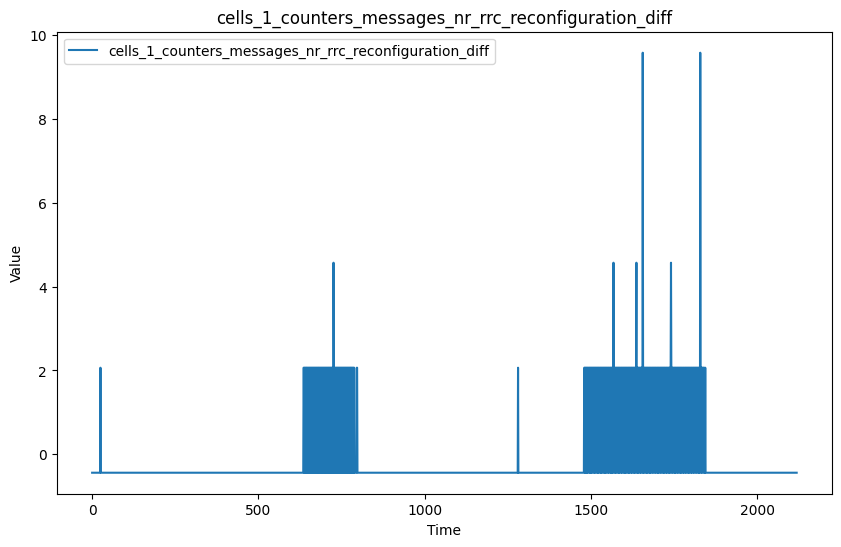

cells_1_counters_messages_nr_rrc_reconfiguration_complete_diff


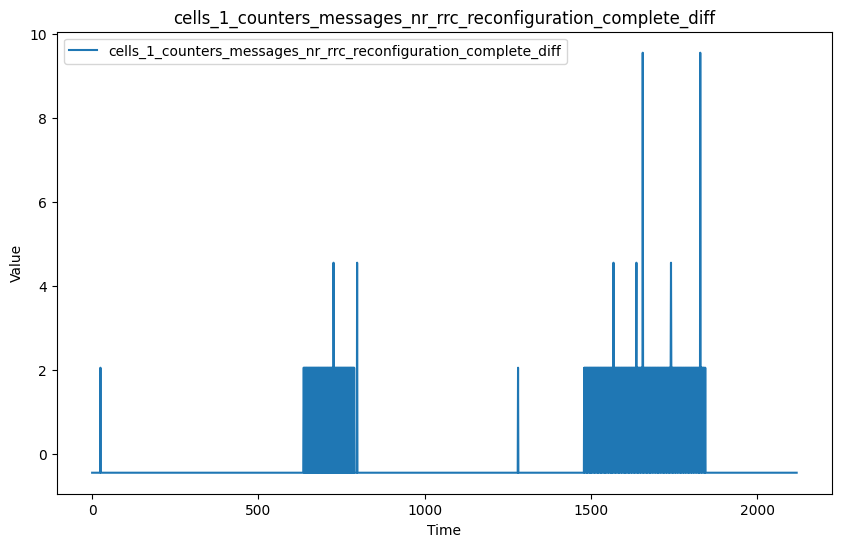

cells_1_counters_messages_nr_rrc_ul_information_transfer_diff


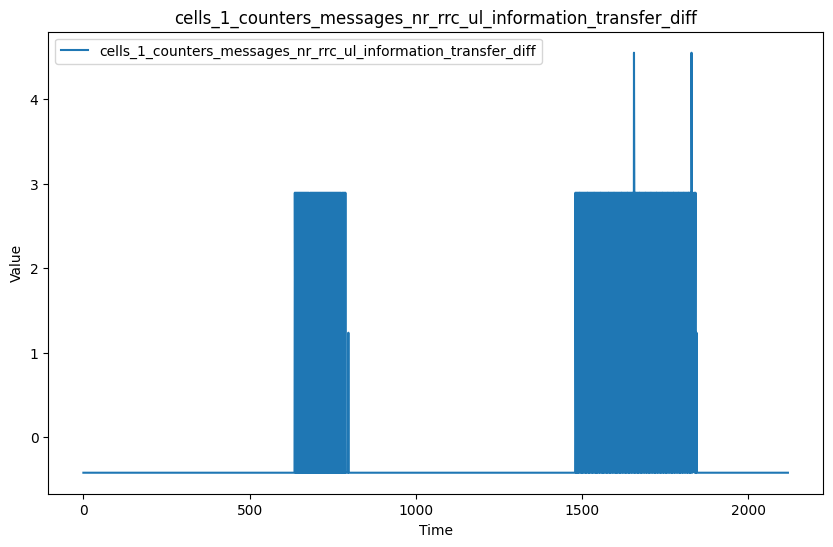

cells_1_drb_count_avg_diff


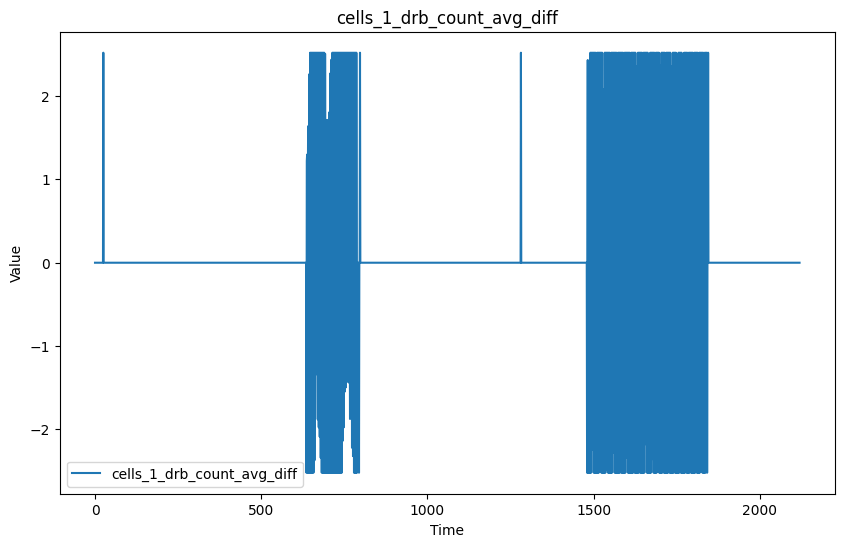

cells_1_drb_count_max_diff


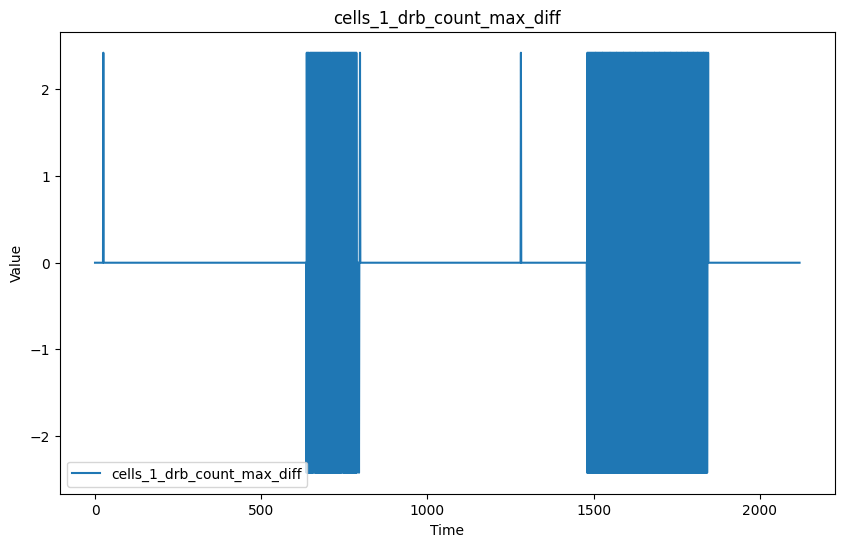

cells_1_drb_count_min_diff


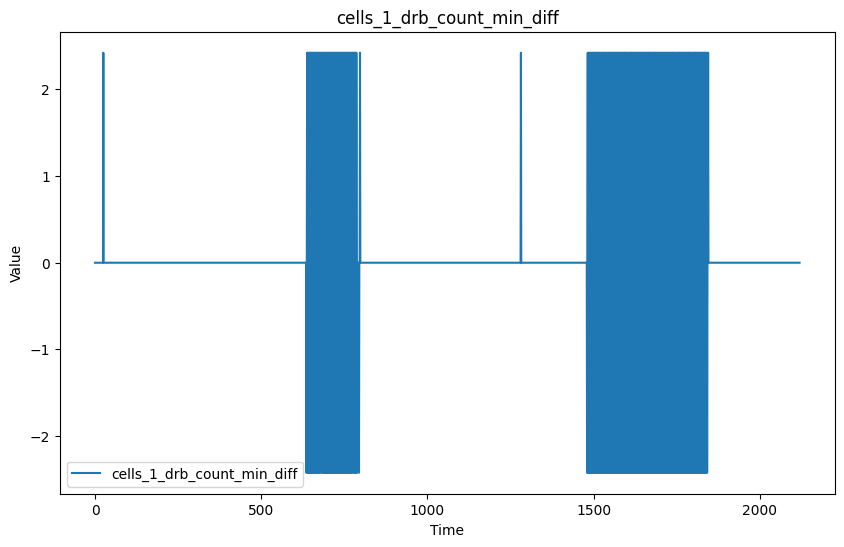

counters_messages_ng_pdu_session_resource_release_command_diff


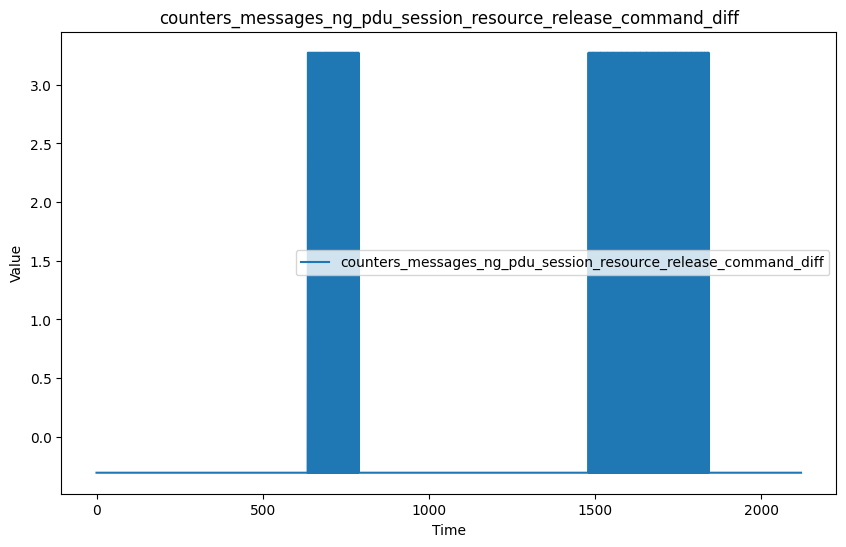

counters_messages_ng_pdu_session_resource_release_response_diff


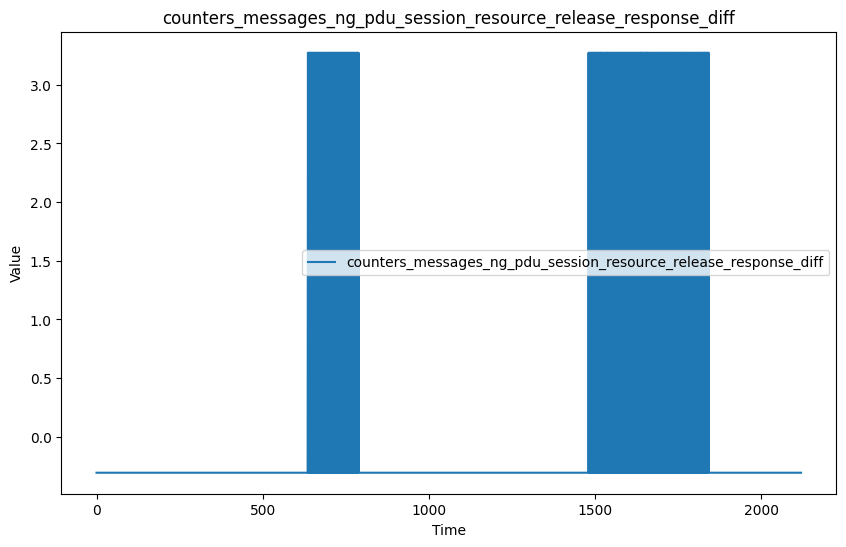

counters_messages_ng_pdu_session_resource_setup_request_diff


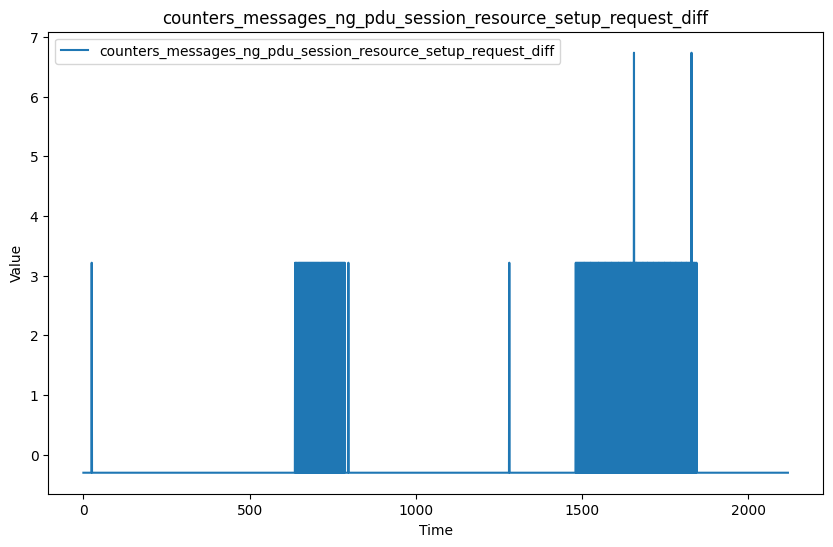

counters_messages_ng_pdu_session_resource_setup_response_diff


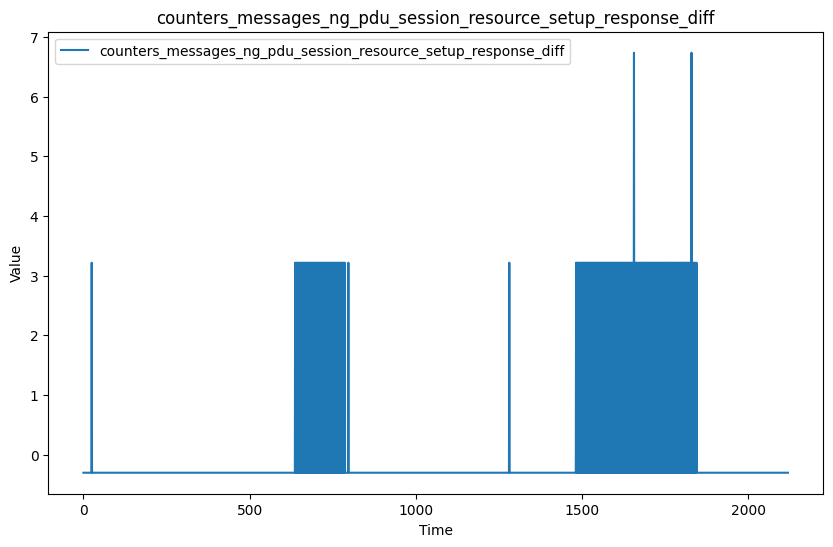

counters_messages_ng_uplink_nas_transport_diff


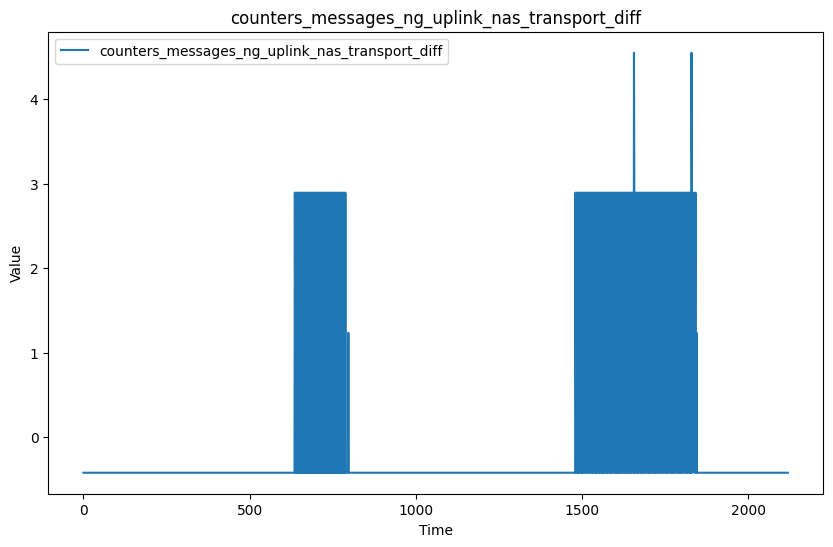

In [4]:
visualize_data(train_df)

In [5]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

# Train Isolation Forest
iforest = IsolationForest(contamination=0.25, random_state=42)
iforest.fit(train_df)
y_pred_iforest = iforest.predict(test_df)
y_pred_iforest = np.where(y_pred_iforest == 1, 0, 1)  # Convert to 0 for normal, 1 for anomaly

# Train Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.25)
y_pred_lof = lof.fit_predict(test_df)
y_pred_lof = np.where(y_pred_lof == 1, 0, 1)  # Convert to 0 for normal, 1 for anomaly

# Train One-Class SVM
ocsvm = OneClassSVM(nu=0.25, kernel='rbf', gamma='auto')
ocsvm.fit(train_df)
y_pred_ocsvm = ocsvm.predict(test_df)
y_pred_ocsvm = np.where(y_pred_ocsvm == 1, 0, 1)  # Convert to 0 for normal, 1 for anomaly

In [6]:
y_true = test_data['anomaly']

test_df['anomalies_iforest'] = y_pred_iforest
test_df['anomalies_lof'] = y_pred_lof
test_df['anomalies_ocsvm'] = y_pred_ocsvm
test_df['anomaly'] = y_true

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_anomaly_detection(df, method):
    y_true = df['anomaly']
    y_pred = df[method]
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1


methods = ['anomalies_iforest', 'anomalies_lof', 'anomalies_ocsvm']

print("\nTest set:")
for method in methods:
    accuracy, precision, recall, f1 = evaluate_anomaly_detection(test_df, method)
    print(f"{method.capitalize()} based anomaly detection: Accuracy = {accuracy:.2f}, Precision = {precision:.2f}, Recall = {recall:.2f}, F1 Score = {f1:.2f}")


Test set:
Anomalies_iforest based anomaly detection: Accuracy = 0.27, Precision = 1.00, Recall = 0.27, F1 Score = 0.42
Anomalies_lof based anomaly detection: Accuracy = 0.14, Precision = 1.00, Recall = 0.14, F1 Score = 0.25
Anomalies_ocsvm based anomaly detection: Accuracy = 0.20, Precision = 1.00, Recall = 0.20, F1 Score = 0.34
